# Google Colab: Access Webcam for Images and Video
This notebook will go through how to access and run code on images and video taken using your webcam.  

For this purpose of this tutorial we will be using OpenCV's Haar Cascade to do face detection on our Webcam image and video.

In [31]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

## Helper Functions
Below are a few helper function to make converting between different image data types and formats.

In [32]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## Haar Cascade Classifier
For this tutorial we will run a simple object detection algorithm called Haar Cascade on our images and video fetched from our webcam. OpenCV has a pre-trained Haar Cascade face detection model.

In [33]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

## Webcam Images
Running code on images taken from webcam is fairly straight-forward. We will utilize code within Google Colab's **Code Snippets** that has a variety of useful code functions to perform various tasks.

We will be using the code snippet for **Camera Capture** to utilize your computer's webcam.

In [34]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


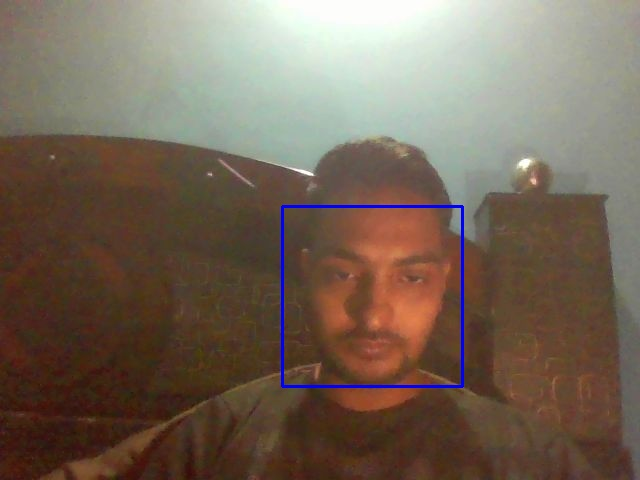

In [46]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [49]:
path="/content/drive/MyDrive/ssd-mobilenet-v2-tensorflow2-fpnlite-320x320-v1"

In [50]:
model = tf.saved_model.load(path)

In [57]:
# image_path = "path/to/your/image.jpg"
image = cv2.imread('photo.jpg')
input_tensor = tf.convert_to_tensor(image)
input_tensor = input_tensor[tf.newaxis, ...]

In [58]:
detections = model(input_tensor)

In [59]:
detection_boxes = detections['detection_boxes'][0].numpy()
detection_scores = detections['detection_scores'][0].numpy()
detection_classes = detections['detection_classes'][0].numpy()

In [60]:
from google.colab.patches import cv2_imshow

In [63]:
import cv2

# Iterate through detections
for i in range(len(detection_scores)):
    if detection_scores[i] > 0.5:  # Confidence threshold
        box = detection_boxes[i]
        class_id = int(detection_classes[i])

        # Scale bounding box coordinates to image dimensions
        height, width, _ = image.shape
        ymin, xmin, ymax, xmax = box
        xmin, xmax, ymin, ymax = int(xmin * width), int(xmax * width), int(ymin * height), int(ymax * height)

        # Draw bounding box
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        # Add label
        label = f"Class {class_id}"  # Replace with class_names[class_id] if available
        cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Show the image with detections
cv2.imread('Detected Objects', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# import cv2
# img = cv2.imread("image", cv2.IMREAD_UNCHANGED)
# cv2_imshow(img)



For example, here we download and display a PNG image of the Colab logo: